<a href="https://colab.research.google.com/github/markusdiekmann95/Morph-U-Net/blob/main/Morph_U_Net_1_Conv_Inria_Vienna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up and Imports

In [ ]:
## Standard libraries
import os
import math
import numpy as np 
import time
import cv2

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)

Using torch 1.10.0+cu111


In [ ]:
torch.manual_seed(42) # Setting the seed
import random
random.seed(42)
np.random.seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Feb 21 14:56:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




# Data Set



In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
from PIL import Image
import random
from scipy import ndimage
from glob import glob
import torch.utils.data as data

class segDataset(data.Dataset):
  def __init__(self, img_path, gt_path, training, transform=None):
        super(segDataset, self).__init__()
        self.training = training
        self.transform = transform
        self.img = img_path
        self.gt = gt_path
        self.images = os.listdir(self.img)

    
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.img, self.images[idx])
    mask_path = os.path.join(self.gt, self.images[idx].replace(".jpg", "_mask.gif"))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    mask[mask == 255.0] = 1.0
    image = np.moveaxis(image, -1, 0)/255

    return torch.Tensor(image), torch.Tensor(mask)

  def __len__(self):
    return len(self.images)
    




In [ ]:
#Initialize the dataset for Inria - https://project.inria.fr/aerialimagelabeling/contest/
data = segDataset("/content/drive/MyDrive/Colab Notebooks/Inria/Prep_Data/img", "/content/drive/MyDrive/Colab Notebooks/Inria/Prep_Data/gt", training=True)

In [ ]:
test_num = int(0.1 * len(data))
print(len(data))
print(test_num)

600
60


In [ ]:
#Split Up Dataset into Train Set and Test Set
train_dataset, test_dataset = torch.utils.data.random_split(data, [len(data)-test_num, test_num], generator=torch.Generator())

In [ ]:
N_DATA, N_TEST = len(train_dataset), len(test_dataset)
print(N_DATA)

540


In [ ]:
# Dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

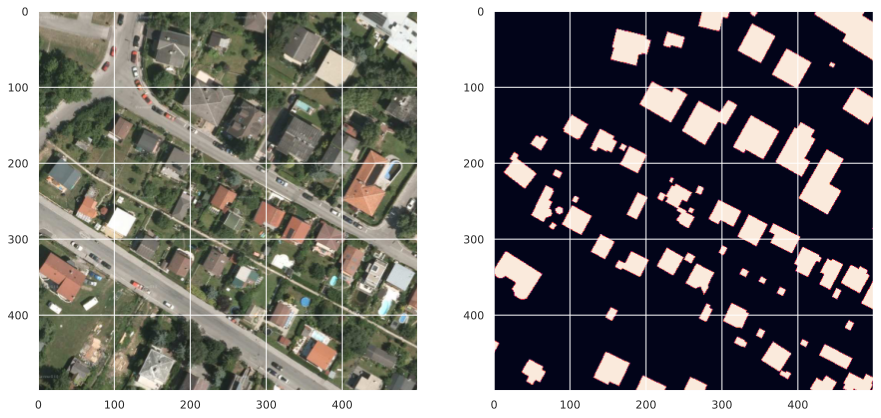

In [ ]:
# Example Plots
d = data[20]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(d[0].permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

#Seed Model for Base Model and Model with Sparse Regularization

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


In [ ]:
def crop_tensor(tensor, target_tensor):
  '''Skip Connections'''
  target_size = target_tensor.size()[2] #2 or 3 for image size
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.red = ([64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024]) #Feature Maps of the Network
        self.conv0_0 = nn.Conv2d(3,self.red[0],kernel_size=3, padding="same")
        self.conv0_1 = nn.Conv2d(self.red[0],self.red[1],kernel_size=3, padding="same")
        self.conv1_0 = nn.Conv2d(self.red[1],self.red[2],kernel_size=3, padding="same")
        self.conv1_1 = nn.Conv2d(self.red[2],self.red[3],kernel_size=3, padding="same")
        self.conv2_0 = nn.Conv2d(self.red[3],self.red[4],kernel_size=3, padding="same")
        self.conv2_1 = nn.Conv2d(self.red[4],self.red[5],kernel_size=3, padding="same")
        self.conv3_0 = nn.Conv2d(self.red[5],self.red[6],kernel_size=3, padding="same")
        self.conv3_1 = nn.Conv2d(self.red[6],self.red[7],kernel_size=3, padding="same")
        self.conv4_0 = nn.Conv2d(self.red[7],self.red[16],kernel_size=3, padding="same")
        self.conv4_1 = nn.Conv2d(self.red[16],self.red[17],kernel_size=3, padding="same")

        self.bn0_0 = nn.BatchNorm2d(self.red[0])
        self.bn0_1 = nn.BatchNorm2d(self.red[1])
        self.bn1_0 = nn.BatchNorm2d(self.red[2])
        self.bn1_1 = nn.BatchNorm2d(self.red[3])
        self.bn2_0 = nn.BatchNorm2d(self.red[4])
        self.bn2_1 = nn.BatchNorm2d(self.red[5])
        self.bn3_0 = nn.BatchNorm2d(self.red[6])
        self.bn3_1 = nn.BatchNorm2d(self.red[7])
        self.bn4_0 = nn.BatchNorm2d(self.red[16])
        self.bn4_1 = nn.BatchNorm2d(self.red[17])
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=self.red[17], out_channels=self.red[7], kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=self.red[9], out_channels=self.red[5], kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=self.red[11], out_channels=self.red[3], kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=self.red[13], out_channels=self.red[1], kernel_size=2, stride=2)

        self.conv5_0 = nn.Conv2d(self.red[7]*2,self.red[8],kernel_size=3, padding="same")
        self.conv5_1 = nn.Conv2d(self.red[8],self.red[9],kernel_size=3, padding="same")
        self.conv6_0 = nn.Conv2d(self.red[5]*2,self.red[10],kernel_size=3, padding="same")
        self.conv6_1 = nn.Conv2d(self.red[10],self.red[11],kernel_size=3, padding="same")
        self.conv7_0 = nn.Conv2d(self.red[3]*2,self.red[12],kernel_size=3, padding="same")
        self.conv7_1 = nn.Conv2d(self.red[12],self.red[13],kernel_size=3, padding="same")
        self.conv8_0 = nn.Conv2d(self.red[1]*2,self.red[14],kernel_size=3, padding="same")
        self.conv8_1 = nn.Conv2d(self.red[14],self.red[15],kernel_size=3, padding="same")

        self.bn5_0 = nn.BatchNorm2d(self.red[8])
        self.bn5_1 = nn.BatchNorm2d(self.red[9])
        self.bn6_0 = nn.BatchNorm2d(self.red[10])
        self.bn6_1 = nn.BatchNorm2d(self.red[11])
        self.bn7_0 = nn.BatchNorm2d(self.red[12])
        self.bn7_1 = nn.BatchNorm2d(self.red[13])
        self.bn8_0 = nn.BatchNorm2d(self.red[14])
        self.bn8_1 = nn.BatchNorm2d(self.red[15])

        self.out = nn.Conv2d(in_channels=self.red[15], out_channels=1, kernel_size=1)#outchannels = num classes

    def forward(self, x):
        #Down
        c0 = self.conv0_0(x)
        c0 = self.relu(c0)
        c0 = self.bn0_0(c0)
        c0 = self.conv0_1(c0)
        c0 = self.relu(c0)
        c0 = self.bn0_1(c0)
        c1 = self.max_pool_2x2(c0)
        c1 = self.conv1_0(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_0(c1)
        c1 = self.conv1_1(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_1(c1)
        c2 = self.max_pool_2x2(c1)
        c2 = self.conv2_0(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_0(c2)
        c2 = self.conv2_1(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_1(c2)
        c3 = self.max_pool_2x2(c2)
        c3 = self.conv3_0(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_0(c3)
        c3 = self.conv3_1(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_1(c3)

        c4 = self.max_pool_2x2(c3)
        c4 = self.conv4_0(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_0(c4)
        c4 = self.conv4_1(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_1(c4)
        #Up
        up = self.up_trans_1(c4)
        y = crop_tensor(c3,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv5_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn5_0(up)
        up = self.conv5_1(up)
        up = self.relu(up)
        up = self.bn5_1(up)
        del c4, y
        up = self.up_trans_2(up)
        y = crop_tensor(c2,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv6_0(torch.cat([up,y], 1))
        self.relu(up)
        up = self.bn6_0(up)
        up = self.conv6_1(up)
        self.relu(up)
        up = self.bn6_1(up)
        
        del c3, y
        up = self.up_trans_3(up)
        y = crop_tensor(c1,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv7_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn7_0(up)
        up = self.conv7_1(up)
        up = self.relu(up)
        up = self.bn7_1(up)
        del c2, y
        up = self.up_trans_4(up)
        y = crop_tensor(c0,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv8_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn8_0(up)
        up = self.conv8_1(up)
        up = self.relu(up)
        up = self.bn8_1(up)
        del c0, c1, y

        x = self.out(up)
        return x

# Model Training Functions and Classes

## Regularization for MorphNet

In [ ]:
#https://leimao.github.io/blog/Group-Lasso/
def group_lasso_reg(layer):
  '''Takes a layer as input and performs group lasso on it'''
  num_w = layer.numel()
  eucl_norm = torch.sqrt(l2_reg(layer))
  return torch.sqrt(torch.tensor(num_w)) * eucl_norm

In [ ]:
def model_size_C(layer):
  '''Takes a layer as input and compute it's model size C '''
  res = torch.tensor(0.)
  x = torch.Tensor(2)
  x[0] = torch.tensor([layer.shape[2]])
  x[1] = torch.tensor([layer.shape[3]])
  res = torch.prod(x)
  return res.cuda()

In [ ]:
def flops_C(layer):
  '''Takes a layer as input and compute it's FLOPs C '''
  if not len(layer.size())==4:
    "Wrong Layer! Len of Size must be 4!"
  x = torch.Tensor(4)
  x[0] = torch.tensor([layer.shape[0]])
  x[1] = torch.tensor([layer.shape[1]])
  x[2] = torch.tensor([layer.shape[2]])
  x[3] = torch.tensor([layer.shape[3]])
  flops = 2 * torch.prod(x)
  return flops.cuda()

In [ ]:
def l1_reg(layer):
  '''Takes a layer as input and performs L1 Regularization on it'''
  l1 = 0
  for param in layer:
    l1 += torch.sum(torch.abs(param))
  return l1

In [ ]:
def l2_reg(layer):
  '''Takes a layer as input and performs L1 Regularization on it'''
  l2 = 0
  for param in layer:
    #for param in filter:
      l2 += torch.sum(torch.pow(param,2))
  return l2

In [ ]:
def zero_out_indicator(layer, threshold=0.0001):
  '''
  layer: Convolution Layer Weights
  threshold: If neuron is below this threshold, it is not alive
  returns: Number of neurons which are alive
  '''
  res = torch.Tensor(layer.size())
  al = 0
  res = torch.where(layer.abs() > torch.tensor(threshold).cuda(), torch.tensor(1.).cuda(), torch.tensor(0.).cuda())
  al = torch.sum(res)
  return al

In [ ]:
def gamma_regularizer(model, threshold=0.0001):
  '''  takes  the model and threshold as input and computes the costs based on
   Gamma L1 Regularization  '''
  last_module = None
  costs = 0.
  for name, param in model.named_parameters():
    if ("conv" in name) and ("weight" in name): # Select Convolution Layer Weights
      model_size = model_size_C(param)
    if ("bn" in name) and ("weight" in name): # Select BN Weights
      if last_module is None:
        #Input
        costs += model_size * zero_out_indicator(param, threshold) * 0 #Model Input - has no gammas
        #Output
        costs += model_size * l1_reg(param) * 3 #First Batchnorm gammas in double conv block, Input channels are always alive!

        last_module = param
      else:  # In the  computation the output of the previous layer is relevant
        #Input
        costs += model_size * l1_reg(last_module) * zero_out_indicator(param) #First Batchnorm gammas in double conv block
        #Output
        costs += model_size * l1_reg(param) * zero_out_indicator(last_module,threshold) #First Batchnorm gammas in double conv block

        last_module = param #To remember the params from the previous layer
  
  return costs

In [ ]:
def group_lasso_regularizer(model, threshold=0.0001):
  ''' Takes the model and threshold as input and 
  computes the costs based on Group Lasso Regularization'''
  last_module = None
  costs = 0.
  for name, param in model.named_parameters():
    if ("conv" in name) and ("weight" in name): # Select Convolution Layer Weights
      if last_module is None: #If the layer is the first convolution layer
        costs += param.size()[2]*param.size()[3] * zero_out_indicator(param.cuda()) * 0 # No regularization on input channels
          #Output
        costs += param.size()[2]*param.size()[3] * group_lasso_reg(param) * 3 # Input channels are always alive
        last_module = param 
      else: # In the  computation the output of the previous layer is relevant
          #Input
        costs += param.size()[2]*param.size()[3] * group_lasso_reg(last_module) * zero_out_indicator(param.cuda(),threshold) 
          #Output
        costs += param.size()[2]*param.size()[3] * group_lasso_reg(param) * zero_out_indicator(last_module.cuda(),threshold) 

        last_module = param #To remember the params from the previous layer
  
  return costs

## Loss ...

In [ ]:
def check_accuracy(loader, model, device="cuda"):
  ''' Takes a dataloader and the model as input and returns
  accuracy and dice score'''

  num_correct = 0
  num_pixels = 0
  dice_score = 0
    
  model.eval()

  with torch.no_grad():
      for x, y in loader:
          x = x.to(device)
          y = y.to(device).unsqueeze(1)
          preds = torch.sigmoid(model(x))
          preds = (preds > 0.5).float()
          num_correct += (preds == y).sum()
          num_pixels += torch.numel(preds)
          dice_score += (2 * (preds * y).sum()) / (
              (preds + y).sum() + 1e-8
          )
  return num_correct/num_pixels, dice_score/len(loader)

In [ ]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
#Credits: https://github.com/tatigabru/inria
class DiceLoss(_Loss):
    """
    Implementation of dice loss 
    for binary image segmentation task, calculated from logits
        Args: 
            log_loss: if True, loss computed as `-log(dice)`; otherwise `1 - dice`
            log_sigmoid: if True, uses F.logsigmoid(y_pred).exp(), otherwise uses torch.sigmoid(y_pred)  
            smooth: smooth the loss values, should be float between 0 and 1
            reduction: str = 'mean', 'sum' or 'none'. Default = 'mean'
        Output: loss as a float or Tensor (for reduction 'none')    
    """
    def __init__(self, log_sigmoid: bool=True, log_loss: bool=False, smooth: float=0.0, reduction: str = 'mean'):

        super(DiceLoss, self).__init__()
  
        self.log_sigmoid = log_sigmoid
        self.log_loss = log_loss
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        """
        Args:
            y_pred: binary masks of shape Nx1xHxW
            y_true: binary masks of shape Nx1xHxW        
        """
        if y_true.size() != y_pred.size(): raise ValueError("Model outputs and targetd mush have the same size: Nx1xHxW")         
        eps = 1e-7

        if self.log_sigmoid:            
            # Log-Exp more numerically stable and does not cause vanishing gradient on
            # extreme values of 0 and 1
            outputs = F.logsigmoid(y_pred).exp()
        else:
            #outputs = y_pred    
            outputs = torch.sigmoid(y_pred)        
        targets = (y_true == 1).type_as(outputs) # ensure the same type

        intersection = torch.sum(outputs * targets)
        cardinality = torch.sum(outputs + targets)
        loss = (intersection + self.smooth) / (cardinality.clamp_min(eps) + self.smooth)
        
        if self.log_loss:
            loss = -torch.log(scores.clamp_min(eps))
        else:
            loss = 1 - loss
        
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()  

        return loss

In [ ]:
#test = torch.rand((1,3,500,500))
#print(model(test).shape)

## Training

In [ ]:
def train_model_with_reg(model, optimizer, data_loader,loss_module, model_save, num_epochs=10, threshold=0.0001, factor=1e-10 ):
  '''Performs the model training with group lasso regularization'''
    # Set model to train mode
  best_score = 0.
  model.train() 
    
  # Training loop
  for epoch in tqdm(range(num_epochs)):
      loss_list = []
      temp_loss_list = []
      acc_list = []
      dic_list = []
      cost_list = []

      for batch_i, (data_inputs,data_labels) in enumerate(data_loader):
           

          data_inputs = data_inputs.to(device) 
          data_labels = data_labels.float().unsqueeze(1).to(device)
          data_inputs.size()
          data_labels.size()
          pred_mask = model(data_inputs)

          costs =  group_lasso_regularizer(model, threshold)#gamma_regularizer(model, model_size_C)
           

            ## TODO: Step 3 - Calculate the loss using the module loss_module
          _temp_loss = loss_module(pred_mask, data_labels) 
          _loss = _temp_loss + factor * costs



            ## TODO: Step 4 - Perform backpropagation
          optimizer.zero_grad()
          _loss.backward()
            #print("success")
            ## TODO: Step 5 - Update parameters
          optimizer.step( )
          loss_list.append(_loss.cpu().detach().numpy())
          temp_loss_list.append(_temp_loss.cpu().detach().numpy())


      accuracy, dice = check_accuracy(train_dataloader, model, device)  
      tr_acc = accuracy.cpu().detach().numpy()    
      tr_dic = dice.cpu().detach().numpy()  
      accuracy, dice = check_accuracy(test_dataloader, model, device)  
      val_acc = accuracy.cpu().detach().numpy()    
      val_dic = dice.cpu().detach().numpy()   
      costs = costs.cpu().detach().numpy()


      if  val_dic >= best_score:
        best_score = val_dic 
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Inria/Models/" + model_save)
      print(' epoch {} - loss : {:.5f} - costs : {:.1f} - total_loss : {:.2f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(temp_loss_list), costs, np.mean(loss_list), tr_acc, tr_dic, val_acc, val_dic)) 
        #print(' epoch {} - loss : {:.5f} - costs : {:.2f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(loss_list), costs, tr_acc, tr_dic, val_acc, val_dic)) 

In [ ]:
def train_model_with_gamma_reg(model, optimizer, data_loader,loss_module, model_save, num_epochs=10, threshold=0.001, factor=1e-4 ):
  '''Performs the model training with gamma l1 regularization'''
  best_score = 0.
  model.train() 
    
  # Training loop
  for epoch in tqdm(range(num_epochs)):
      loss_list = []
      temp_loss_list = []
      acc_list = []
      dic_list = []
      cost_list = []

      for batch_i, (data_inputs,data_labels) in enumerate(data_loader):
            

          data_inputs = data_inputs.to(device) 
          data_labels = data_labels.float().unsqueeze(1).to(device)
          data_inputs.size()
          data_labels.size()

          pred_mask = model(data_inputs)


          costs =  gamma_regularizer(model, threshold)#gamma_regularizer(model, model_size_C)
            

            ## TODO: Step 3 - Calculate the loss using the module loss_module
          _temp_loss = loss_module(pred_mask, data_labels) 
          _loss = _temp_loss + factor * costs


            ## TODO: Step 4 - Perform backpropagation
          optimizer.zero_grad()
          _loss.backward()

            ## TODO: Step 5 - Update parameters
          optimizer.step( )
          loss_list.append(_loss.cpu().detach().numpy())
          temp_loss_list.append(_temp_loss.cpu().detach().numpy())


      accuracy, dice = check_accuracy(train_dataloader, model, device)  
      tr_acc = accuracy.cpu().detach().numpy()    
      tr_dic = dice.cpu().detach().numpy()  
      accuracy, dice = check_accuracy(test_dataloader, model, device)  
      val_acc = accuracy.cpu().detach().numpy()    
      val_dic = dice.cpu().detach().numpy()   
      costs = costs.cpu().detach().numpy()

      if  val_dic >= best_score:
        best_score = val_dic 
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Inria/Models/" + model_save)
      print(' epoch {} - loss : {:.5f} - costs : {:.1f} - total_loss : {:.2f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(temp_loss_list), costs, np.mean(loss_list), tr_acc, tr_dic, val_acc, val_dic)) 
        #print(' epoch {} - loss : {:.5f} - costs : {:.2f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(loss_list), costs, tr_acc, tr_dic, val_acc, val_dic)) 

In [ ]:
def train_model(model, optimizer, data_loader,loss_module, model_save, num_epochs=10):
  '''Performs the model training without regularization'''
  best_score = 0.
  model.train() 
    
    # Training loop
  for epoch in tqdm(range(num_epochs)):
      loss_list = []
      acc_list = []
      dic_list = []
      cost_list = []

      for batch_i, (data_inputs,data_labels) in enumerate(data_loader):
            

          data_inputs = data_inputs.to(device) 
          data_labels = data_labels.float().unsqueeze(1).to(device)
          data_inputs.size()
          data_labels.size()

          pred_mask = model(data_inputs)

            ## TODO: Step 3 - Calculate the loss using the module loss_module
          _loss = loss_module(pred_mask, data_labels) 

            ## TODO: Step 4 - Perform backpropagation
          optimizer.zero_grad()
          _loss.backward()
            #print("success")
            ## TODO: Step 5 - Update parameters
          optimizer.step( )
          loss_list.append(_loss.cpu().detach().numpy())


      accuracy, dice = check_accuracy(train_dataloader, model, device)  
      tr_acc = accuracy.cpu().detach().numpy()    
      tr_dic = dice.cpu().detach().numpy()  
      accuracy, dice = check_accuracy(test_dataloader, model, device)  
      val_acc = accuracy.cpu().detach().numpy()    
      val_dic = dice.cpu().detach().numpy()   

      if  val_dic >= best_score:
        best_score = val_dic 
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Inria/Models/" + model_save)
      print(' epoch {} - loss : {:.5f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(loss_list), tr_acc, tr_dic, val_acc, val_dic)) 

## Evaluation

In [ ]:
def eval_model(model, data_loader):
  '''Create Predictions on the model'''
  model.eval()

  for batch_i, (x, y) in enumerate(data_loader):
      for j in range(2):
          result = model(x.to(device)[j:j+1])
          mask = torch.sigmoid(result.cpu())
          mask = (mask > 0.5).float()
          mask = mask.reshape(500,500)
          im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
          im = im.astype(int)
          gt_mask = y[j]
          plt.figure(figsize=(12,12))
          plt.subplot(1,3,1)
          im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
          im = im.astype(int)
          plt.grid(b=False)
          plt.axis('off')
          plt.imshow(im)

          plt.subplot(1,3,2)
          plt.grid(b=False)
          plt.axis('off')
          plt.imshow(gt_mask)

          plt.subplot(1,3,3)
          plt.grid(b=False)
          plt.axis('off')
          plt.imshow(mask)

          plt.show()

# Train Base Model without Sparse Regularization (For Comparison)

## Initialize Model

In [ ]:
base_model = UNet()
base_model.to(device)

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3_0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4_0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up_trans_1): Conv

In [ ]:
from torchsummary import summary
summary(base_model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 500, 500]           1,792
              ReLU-2         [-1, 64, 500, 500]               0
       BatchNorm2d-3         [-1, 64, 500, 500]             128
         MaxPool2d-4         [-1, 64, 250, 250]               0
            Conv2d-5        [-1, 128, 250, 250]          73,856
              ReLU-6        [-1, 128, 250, 250]               0
       BatchNorm2d-7        [-1, 128, 250, 250]             256
         MaxPool2d-8        [-1, 128, 125, 125]               0
            Conv2d-9        [-1, 256, 125, 125]         295,168
             ReLU-10        [-1, 256, 125, 125]               0
      BatchNorm2d-11        [-1, 256, 125, 125]             512
        MaxPool2d-12          [-1, 256, 62, 62]               0
           Conv2d-13          [-1, 512, 62, 62]       1,180,160
             ReLU-14          [-1, 512,

## Train Model

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model(base_model, optimizer, train_dataloader, loss_module, model_save="base_model", num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.70375 - tr_acc : 0.83 - tr-dic : 0.71 - val_acc : 0.84 - val-dic : 0.71 
 epoch 1 - loss : 0.61298 - tr_acc : 0.91 - tr-dic : 0.80 - val_acc : 0.91 - val-dic : 0.80 
 epoch 2 - loss : 0.60323 - tr_acc : 0.90 - tr-dic : 0.80 - val_acc : 0.91 - val-dic : 0.80 
 epoch 3 - loss : 0.59681 - tr_acc : 0.91 - tr-dic : 0.79 - val_acc : 0.91 - val-dic : 0.78 
 epoch 4 - loss : 0.59022 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.79 
 epoch 5 - loss : 0.58769 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.82 
 epoch 6 - loss : 0.58631 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.93 - val-dic : 0.83 
 epoch 7 - loss : 0.57714 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.93 - val-dic : 0.83 
 epoch 8 - loss : 0.57642 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc : 0.93 - val-dic : 0.81 
 epoch 9 - loss : 0.57589 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc : 0.93 - val-dic : 0.83 
 epoch 10 - loss : 0.58169 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc :

N_Parameter: 15,330,625 \
Time: 32:49 \
Tr_Acc: 0.97 \
Tr_Dice: 0.93 \
Val_Acc: 0.94 \
Val-Dic: 0.86 

### Predictions

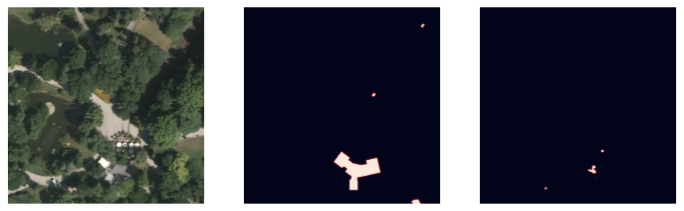

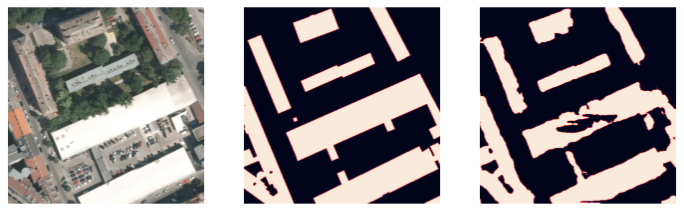

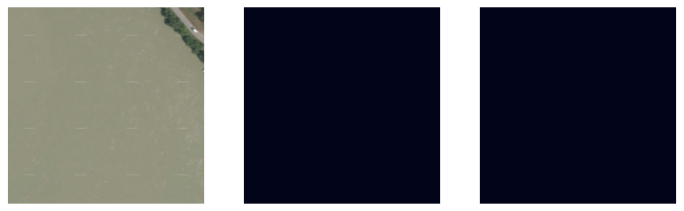

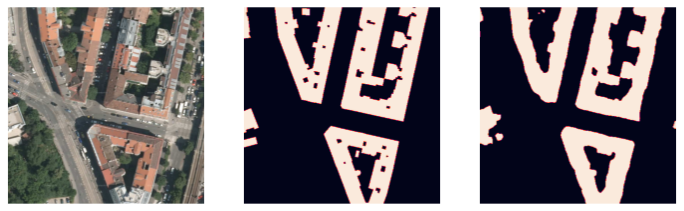

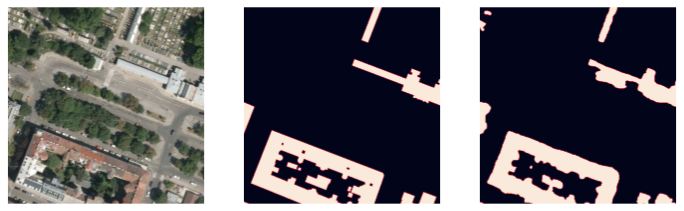

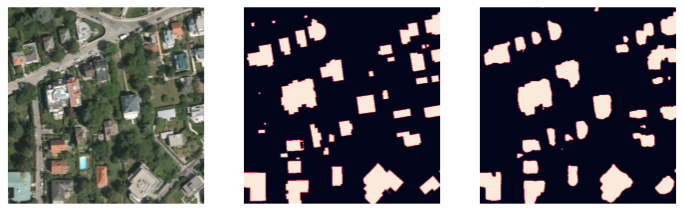

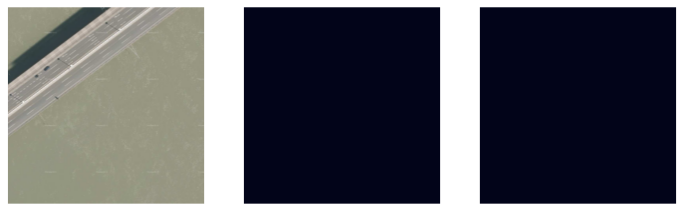

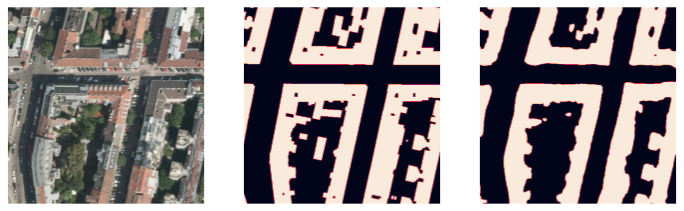

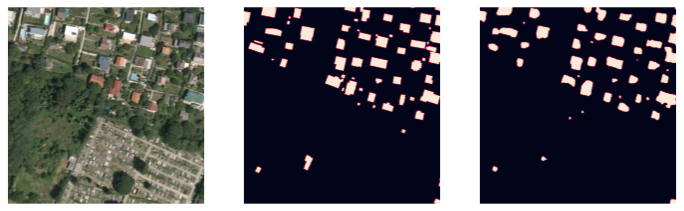

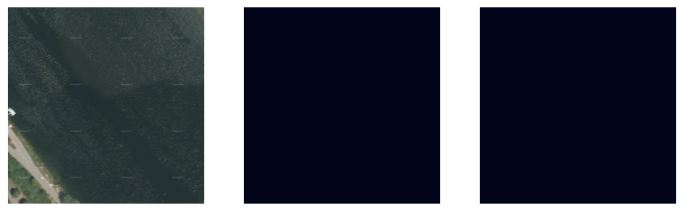

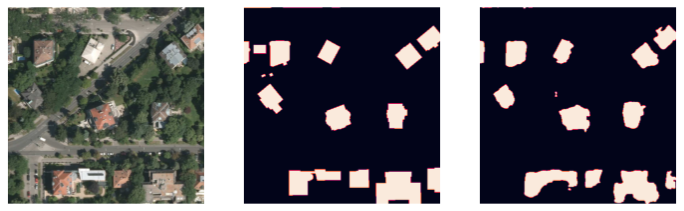

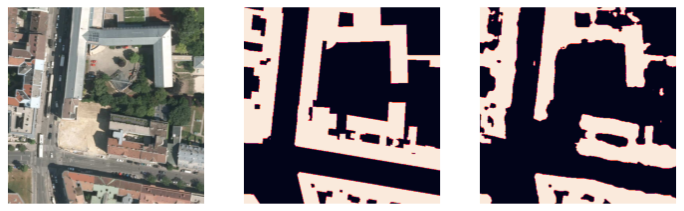

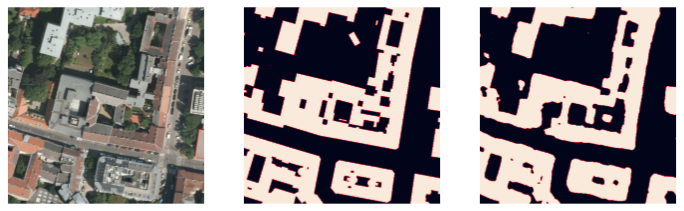

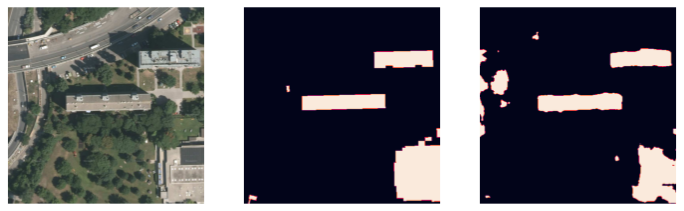

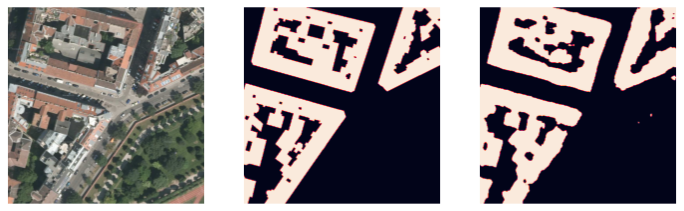

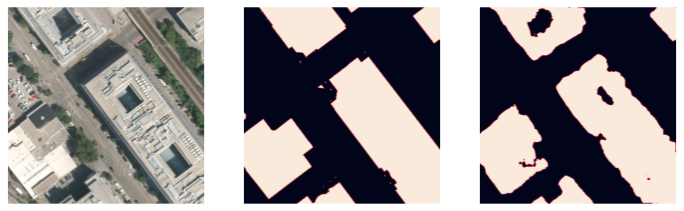

In [ ]:
eval_model(base_model, test_dataloader)

# Step 1 Training with Sparse Regularization

## Initialize Model

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()
model = UNet()
model.to(device)

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3_0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4_0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up_trans_1): Conv

In [ ]:
from torchsummary import summary
summary(model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 500, 500]           1,792
              ReLU-2         [-1, 64, 500, 500]               0
       BatchNorm2d-3         [-1, 64, 500, 500]             128
         MaxPool2d-4         [-1, 64, 250, 250]               0
            Conv2d-5        [-1, 128, 250, 250]          73,856
              ReLU-6        [-1, 128, 250, 250]               0
       BatchNorm2d-7        [-1, 128, 250, 250]             256
         MaxPool2d-8        [-1, 128, 125, 125]               0
            Conv2d-9        [-1, 256, 125, 125]         295,168
             ReLU-10        [-1, 256, 125, 125]               0
      BatchNorm2d-11        [-1, 256, 125, 125]             512
        MaxPool2d-12          [-1, 256, 62, 62]               0
           Conv2d-13          [-1, 512, 62, 62]       1,180,160
             ReLU-14          [-1, 512,

## Train Model with Sparse Regularization

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model_with_reg(model, optimizer, train_dataloader, loss_module, model_save="gl_reg_model", num_epochs= 20, threshold=0.01, factor=1e-2)

  0%|          | 0/20 [00:00<?, ?it/s]

 epoch 0 - loss : 0.78402 - costs : 90379673600.0 - total_loss : 3865672960.00 - tr_acc : 0.81 - tr-dic : 0.64 - val_acc : 0.83 - val-dic : 0.66 
 epoch 1 - loss : 0.70813 - costs : 23861231616.0 - total_loss : 533966496.00 - tr_acc : 0.81 - tr-dic : 0.64 - val_acc : 0.83 - val-dic : 0.66 
 epoch 2 - loss : 0.78781 - costs : 5482689024.0 - total_loss : 113530744.00 - tr_acc : 0.54 - tr-dic : 0.49 - val_acc : 0.55 - val-dic : 0.47 
 epoch 3 - loss : 0.80113 - costs : 1420301696.0 - total_loss : 27706978.00 - tr_acc : 0.43 - tr-dic : 0.44 - val_acc : 0.44 - val-dic : 0.41 
 epoch 4 - loss : 0.81768 - costs : 110016888.0 - total_loss : 5228927.00 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.36 
 epoch 5 - loss : 0.82049 - costs : 90199840.0 - total_loss : 997657.88 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.35 
 epoch 6 - loss : 0.81715 - costs : 85399976.0 - total_loss : 909418.94 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.37 
 ep

N_Parameter: 31,043,521 \
Time: 50:05  \
Tr_Acc: 0.88 \
Tr_Dice: 0.75 \
Val_Acc: 0.89 \
Val-Dic: 0.75 

### Predictions


In [ ]:
eval_model(model, test_dataloader)

## With Gamma Reg

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model_with_gamma_reg(model, optimizer, train_dataloader, loss_module, num_epochs= 10, model_save="gm_reg_model", threshold=0.01)

  0%|          | 0/10 [00:00<?, ?it/s]

 epoch 0 - loss : 0.79774 - costs : 876734.6 - total_loss : 88.77 - tr_acc : 0.83 - tr-dic : 0.63 - val_acc : 0.84 - val-dic : 0.64 
 epoch 1 - loss : 0.71957 - costs : 870738.6 - total_loss : 88.09 - tr_acc : 0.87 - tr-dic : 0.72 - val_acc : 0.88 - val-dic : 0.72 
 epoch 2 - loss : 0.63140 - costs : 864741.1 - total_loss : 87.40 - tr_acc : 0.88 - tr-dic : 0.76 - val_acc : 0.89 - val-dic : 0.75 
 epoch 3 - loss : 0.61890 - costs : 858745.1 - total_loss : 86.79 - tr_acc : 0.90 - tr-dic : 0.77 - val_acc : 0.90 - val-dic : 0.77 
 epoch 4 - loss : 0.61063 - costs : 852749.4 - total_loss : 86.18 - tr_acc : 0.90 - tr-dic : 0.79 - val_acc : 0.90 - val-dic : 0.78 
 epoch 5 - loss : 0.60671 - costs : 846754.4 - total_loss : 85.58 - tr_acc : 0.90 - tr-dic : 0.79 - val_acc : 0.90 - val-dic : 0.79 
 epoch 6 - loss : 0.59987 - costs : 840759.1 - total_loss : 84.97 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.79 
 epoch 7 - loss : 0.59870 - costs : 834764.9 - total_loss : 84.37 - t

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Inria/Models/model.pt"))

<All keys matched successfully>

In [ ]:
print(model.bn0_1.weight)
print(model.bn2_1.weight)

Parameter containing:
tensor([0.9536, 0.9600, 0.9427, 0.9468, 0.9564, 0.9487, 0.9374, 0.9405],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.9320, 0.9320, 0.9320, 0.9320, 0.9320, 0.9320, 0.9320, 0.9322, 0.9323,
        0.9320, 0.9320, 0.9320, 0.9320, 0.9320, 0.9321, 0.9320, 0.9321, 0.9322,
        0.9320, 0.9320, 0.9320, 0.9320, 0.9320, 0.9320, 0.9320, 0.9322, 0.9320,
        0.9320, 0.9321, 0.9320, 0.9321, 0.9321], device='cuda:0',
       requires_grad=True)


# Step 2 Set up and train shrinked Model

## Sparsifying Functions

In [ ]:
# Functions are based on https://github.com/stephenjfox/Morph.py/blob/master/morph/nn/shrink.py
# Own adjustment / extensions
def new_layers_in_percentage(model, type="conv",dead_layers=False, threshold=0.0001):
  ''' Returns the new layer sizes in percentage'''
  len_l = 0
  for name, param in model.named_parameters():
    if ("conv" in name) and ("weight" in name):
      len_l += 1
  layer_reduction = np.zeros(len_l)
  i = 0
  if type=="conv":
    for name, param in model.named_parameters():
      if ("conv" in name) and ("weight" in name):
          layer_reduction[i] = percentage_waste_conv(param,threshold)
          i+=1
  layer_reduction = 1 - layer_reduction
  if dead_layers is False:
    for i in range(1,len(layer_reduction)):
      if layer_reduction[i] == 0:
        layer_reduction[i] = layer_reduction[i-1]
  return layer_reduction

def sparsify(weights, threshold=0.0001):
  '''
  @weights: all weights of a layer
  @threshold: all absolute values of weights below this threshold are zero
  @return: weights where dead weights are zero
  '''
  w = weights.cpu()
  res = w.where(w.abs() > torch.tensor(threshold).cpu(), torch.tensor(0.).cpu())
  return res

def percentage_waste(layer, threshold=0.0001):
  w = layer.weight
  sparsified_w = sparsify(w, threshold)
  if sparsified_w.max() == 0:
    return 1.
  non_sparse_w = torch.nonzero(sparsified_w)

  return 1-(non_sparse_w.numel()/(w.numel()+1e-10))

def percentage_waste_conv(layer, threshold=0.0001):
  '''
  @layer: weights of a layer
  @threshold: all absolute values of weights below this threshold are zero
  @return: number of dead weights in percentage for a layer
  '''
  w = layer
  sparsified_w = sparsify(w, threshold)
  if sparsified_w.max() == 0:
    return 1.
  non_sparse_w = torch.nonzero(torch.flatten(sparsified_w))
  return 1-(non_sparse_w.numel()/(w.numel()+1e-10))

## Shrinked Model

In [ ]:
def make_symmetry(fac, min_fac=0.0):
  ''' Computes layer sizes for symmetry level 3'''
  res = np.zeros(len(fac))
  len_f = len(fac)-2
  len_left = int((len(fac)-2)/2)
  for i in range(0,len_left,2):
    res[i] = res[i+1] = res[len_f-i-1] = res[len_f-i-2] = max(fac[i], fac[i+1], fac[len_f-i-1], fac[len_f-i-2], min_fac)
  res[len(fac)-1] = res[len(fac)-2] = max(fac[len(fac)-1], fac[len(fac)-2], min_fac)
  return res

In [ ]:
#Symmetry Level !!!Only developed for U-Net with double convolution blocks!!!
# 1 Crop == Transpose
# 2 Equal Double Conv Size
# 3 Same Number of Feature Maps in Contracting and Expansive Path
class ShrinkedUNet(nn.Module):
    def __init__(self, fac, symmetry_level=1, min_fac=0.0):
        super().__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.fac = fac
        if symmetry_level == 1:
          for i in range(0,len(self.fac)):
            self.fac[i] = max(self.fac[i], min_fac)
        if symmetry_level == 2:
          for i in range(0,len(fac),2):
            self.fac[i] =  self.fac[i+1] = max(self.fac[i],self.fac[i+1], min_fac)
        if symmetry_level == 3:
          self.fac = make_symmetry(self.fac, min_fac)
          
        self.red = (([64,128,256,512,512,256,128,64,1024]) * self.fac).astype(int)

        self.conv0_0 = nn.Conv2d(3,self.red[0],kernel_size=3, padding="same")
        self.conv1_0 = nn.Conv2d(self.red[0],self.red[1],kernel_size=3, padding="same")
        self.conv2_0 = nn.Conv2d(self.red[1],self.red[2],kernel_size=3, padding="same")
        self.conv3_0 = nn.Conv2d(self.red[2],self.red[3],kernel_size=3, padding="same")
        self.conv4_0 = nn.Conv2d(self.red[3],self.red[8],kernel_size=3, padding="same") #bottom

        self.bn0_0 = nn.BatchNorm2d(self.red[0])
        self.bn1_0 = nn.BatchNorm2d(self.red[1])
        self.bn2_0 = nn.BatchNorm2d(self.red[2])
        self.bn3_0 = nn.BatchNorm2d(self.red[3])
        self.bn4_0 = nn.BatchNorm2d(self.red[8])
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=self.red[8], out_channels=self.red[3], kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=self.red[4], out_channels=self.red[2], kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=self.red[5], out_channels=self.red[1], kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=self.red[6], out_channels=self.red[0], kernel_size=2, stride=2)

        self.conv5_0 = nn.Conv2d(self.red[3]*2,self.red[4],kernel_size=3, padding="same")
        self.conv6_0 = nn.Conv2d(self.red[2]*2,self.red[5],kernel_size=3, padding="same")
        self.conv7_0 = nn.Conv2d(self.red[1]*2,self.red[6],kernel_size=3, padding="same")
        self.conv8_0 = nn.Conv2d(self.red[0]*2,self.red[7],kernel_size=3, padding="same")

        self.bn5_0 = nn.BatchNorm2d(self.red[4])
        self.bn6_0 = nn.BatchNorm2d(self.red[5])
        self.bn7_0 = nn.BatchNorm2d(self.red[6])
        self.bn8_0 = nn.BatchNorm2d(self.red[7])

        self.out = nn.Conv2d(in_channels=self.red[7], out_channels=1, kernel_size=1)#outchannels = num classes

    def forward(self, x):
        #Down
        #print(x.size())
        c0 = self.conv0_0(x)
        c0 = self.relu(c0)
        c0 = self.bn0_0(c0)
        #print(c0.size())
        c1 = self.max_pool_2x2(c0)
        c1 = self.conv1_0(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_0(c1)
        #print(c1.size())
        c2 = self.max_pool_2x2(c1)
        c2 = self.conv2_0(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_0(c2)
       # print(c2.size())
        c3 = self.max_pool_2x2(c2)
        c3 = self.conv3_0(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_0(c3)

        c4 = self.max_pool_2x2(c3)
        c4 = self.conv4_0(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_0(c4)

        #print(c3.size())
        #print("success")
        #Up
        up = self.up_trans_1(c4)
        y = crop_tensor(c3,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv5_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn5_0(up)

        del c4, y
        up = self.up_trans_2(up)
        y = crop_tensor(c2,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv6_0(torch.cat([up,y], 1))
        self.relu(up)
        up = self.bn6_0(up)
        
        del c3, y
        #print(up.size())
        up = self.up_trans_3(up)
        y = crop_tensor(c1,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv7_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn7_0(up)
        del c2, y
       # print(up.size())
        up = self.up_trans_4(up)
        y = crop_tensor(c0,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv8_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn8_0(up)

        #print(up.size())
        del c0, c1, y

        x = self.out(up)
        #print(x.size())
        return x

## Symmetry Level 1

### Initialize Shrinked UNet

In [ ]:
new_layer_size_in_percentage = new_layers_in_percentage(model, threshold=0.01)
print(new_layer_size_in_percentage)

[0.41087963 0.35491265 0.35491265 0.20316993 0.20316993 0.20316993
 0.20316993 0.18852403 0.18852403]


In [ ]:
#Example
temp = [0.98090278, 0.90814887, 0.6, 0.351081,   0.35324097, 0.42506944,
 0.3353992,  0.3053992,  0.66553992,  0.4053992,  0.6553992,  0.6953992,
 0.353992,  0.45435737, 0.08598836, 0.48843045, 0.74083116, 0.94902886]

In [ ]:
shrinked_model = ShrinkedUNet(fac=np.array(new_layer_size_in_percentage), symmetry_level=1, min_fac=0.10)

In [ ]:
shrinked_model.to(device)

ShrinkedUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(26, 45, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(45, 90, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(90, 104, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(104, 193, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_0): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_0): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3_0): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4_0): BatchNorm2d(193, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up_trans_1): Conv

In [ ]:
from torchsummary import summary
summary(shrinked_model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 26, 500, 500]             728
              ReLU-2         [-1, 26, 500, 500]               0
       BatchNorm2d-3         [-1, 26, 500, 500]              52
         MaxPool2d-4         [-1, 26, 250, 250]               0
            Conv2d-5         [-1, 45, 250, 250]          10,575
              ReLU-6         [-1, 45, 250, 250]               0
       BatchNorm2d-7         [-1, 45, 250, 250]              90
         MaxPool2d-8         [-1, 45, 125, 125]               0
            Conv2d-9         [-1, 90, 125, 125]          36,540
             ReLU-10         [-1, 90, 125, 125]               0
      BatchNorm2d-11         [-1, 90, 125, 125]             180
        MaxPool2d-12           [-1, 90, 62, 62]               0
           Conv2d-13          [-1, 104, 62, 62]          84,344
             ReLU-14          [-1, 104,

### Train Shrinked Model

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(shrinked_model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model(shrinked_model, optimizer, train_dataloader, loss_module, model_save="shrinked_model", num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.78606 - tr_acc : 0.76 - tr-dic : 0.63 - val_acc : 0.77 - val-dic : 0.63 
 epoch 1 - loss : 0.64729 - tr_acc : 0.87 - tr-dic : 0.75 - val_acc : 0.89 - val-dic : 0.76 
 epoch 2 - loss : 0.62070 - tr_acc : 0.89 - tr-dic : 0.77 - val_acc : 0.90 - val-dic : 0.78 
 epoch 3 - loss : 0.61316 - tr_acc : 0.90 - tr-dic : 0.79 - val_acc : 0.91 - val-dic : 0.79 
 epoch 4 - loss : 0.60789 - tr_acc : 0.91 - tr-dic : 0.80 - val_acc : 0.91 - val-dic : 0.80 
 epoch 5 - loss : 0.60549 - tr_acc : 0.90 - tr-dic : 0.80 - val_acc : 0.90 - val-dic : 0.79 
 epoch 6 - loss : 0.60029 - tr_acc : 0.91 - tr-dic : 0.79 - val_acc : 0.91 - val-dic : 0.79 
 epoch 7 - loss : 0.60361 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 8 - loss : 0.59798 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 9 - loss : 0.59241 - tr_acc : 0.92 - tr-dic : 0.82 - val_acc : 0.92 - val-dic : 0.81 
 epoch 10 - loss : 0.59198 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc :

N_Parameter: 9,654,197 \
Time: 31,21 \
Tr_Acc: 0.96 \
Tr_Dice: 0.91 \
Val_Acc: 0.94 \
Val-Dic: 0.87
 

### Predictions

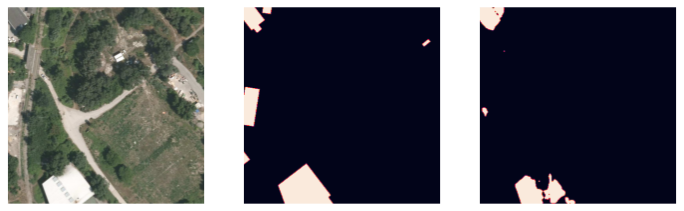

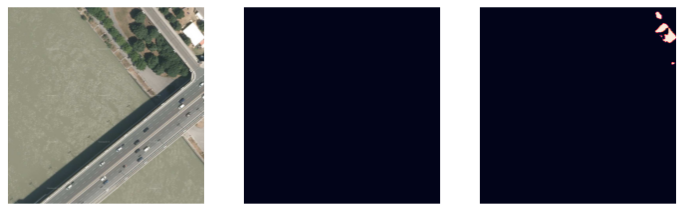

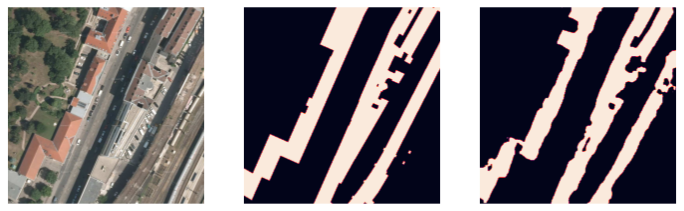

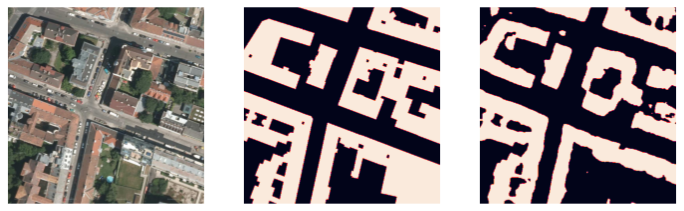

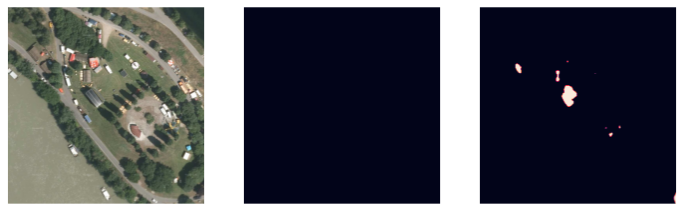

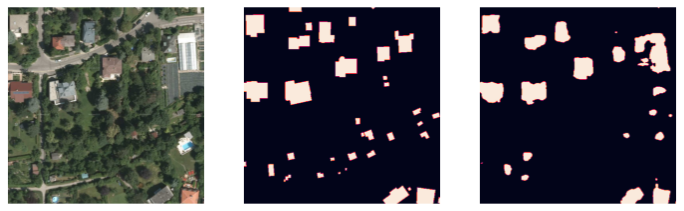

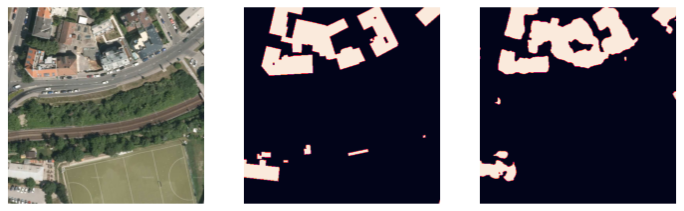

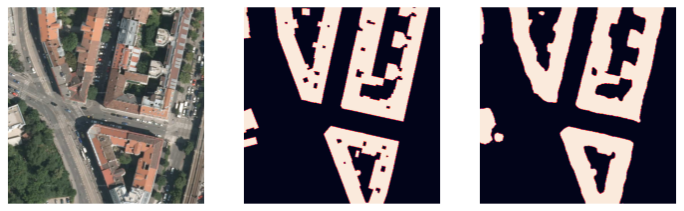

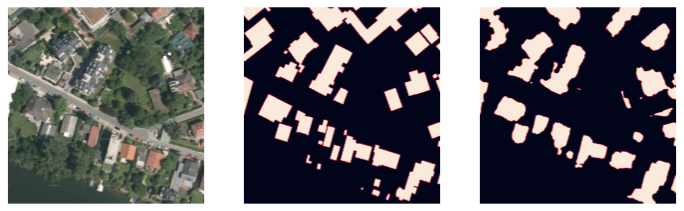

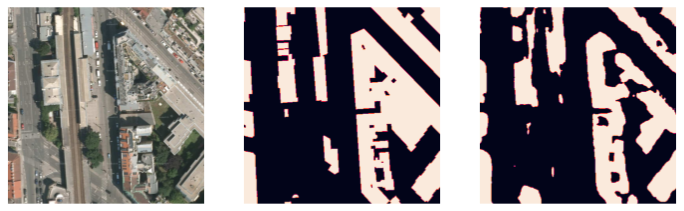

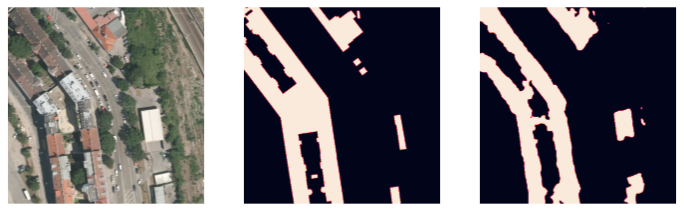

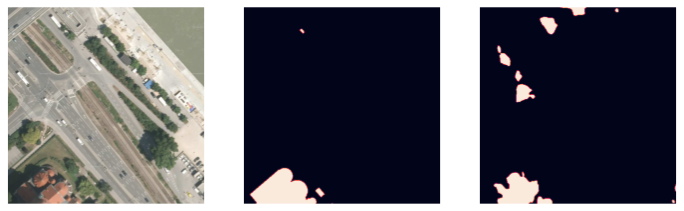

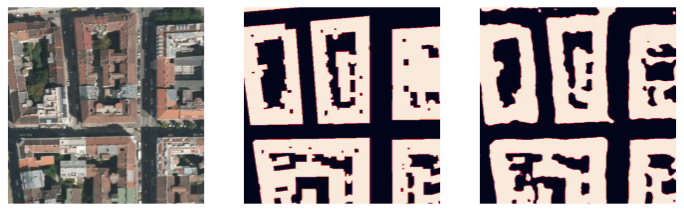

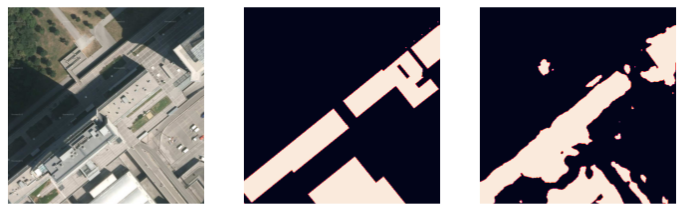

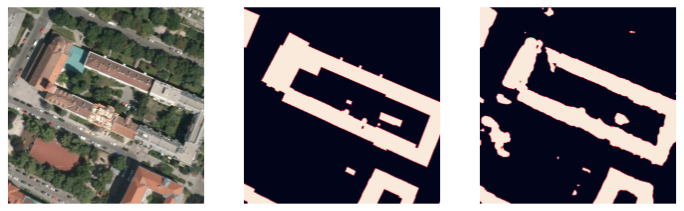

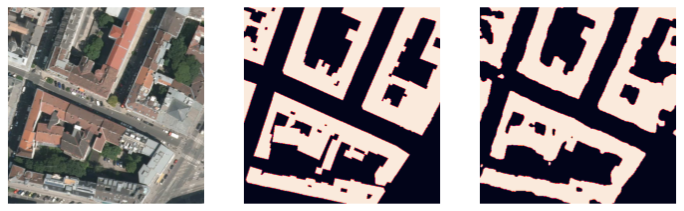

In [ ]:
eval_model(shrinked_model, test_dataloader)

# Step 3 Expanding

## Expanded Model

In [ ]:
class ExpUNet(nn.Module):
    def __init__(self, fac, exp, symmetry_level=1, min_fac=0.0):
        super().__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.fac = fac
        if symmetry_level == 1:
          for i in range(0,len(self.fac)):
            self.fac[i] = max(self.fac[i], min_fac)
        if symmetry_level == 2:
          for i in range(0,len(fac),2):
            self.fac[i] =  self.fac[i+1] = max(self.fac[i],self.fac[i+1], min_fac)
        if symmetry_level == 3:
          self.fac = make_symmetry(self.fac, min_fac)
        #print(self.fac)
        self.red = (([64,128,256,512,512,256,128,64,1024]) * self.fac * exp).astype(int)

        self.conv0_0 = nn.Conv2d(3,self.red[0],kernel_size=3, padding="same")
        self.conv1_0 = nn.Conv2d(self.red[0],self.red[1],kernel_size=3, padding="same")
        self.conv2_0 = nn.Conv2d(self.red[1],self.red[2],kernel_size=3, padding="same")
        self.conv3_0 = nn.Conv2d(self.red[2],self.red[3],kernel_size=3, padding="same")
        self.conv4_0 = nn.Conv2d(self.red[3],self.red[8],kernel_size=3, padding="same") #bottom

        self.bn0_0 = nn.BatchNorm2d(self.red[0])
        self.bn1_0 = nn.BatchNorm2d(self.red[1])
        self.bn2_0 = nn.BatchNorm2d(self.red[2])
        self.bn3_0 = nn.BatchNorm2d(self.red[3])
        self.bn4_0 = nn.BatchNorm2d(self.red[8])
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=self.red[8], out_channels=self.red[3], kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=self.red[4], out_channels=self.red[2], kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=self.red[5], out_channels=self.red[1], kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=self.red[6], out_channels=self.red[0], kernel_size=2, stride=2)

        self.conv5_0 = nn.Conv2d(self.red[3]*2,self.red[4],kernel_size=3, padding="same")
        self.conv6_0 = nn.Conv2d(self.red[2]*2,self.red[5],kernel_size=3, padding="same")
        self.conv7_0 = nn.Conv2d(self.red[1]*2,self.red[6],kernel_size=3, padding="same")
        self.conv8_0 = nn.Conv2d(self.red[0]*2,self.red[7],kernel_size=3, padding="same")

        self.bn5_0 = nn.BatchNorm2d(self.red[4])
        self.bn6_0 = nn.BatchNorm2d(self.red[5])
        self.bn7_0 = nn.BatchNorm2d(self.red[6])
        self.bn8_0 = nn.BatchNorm2d(self.red[7])

        self.out = nn.Conv2d(in_channels=self.red[7], out_channels=1, kernel_size=1)#outchannels = num classes

    def forward(self, x):
        #Down
        #print(x.size())
        c0 = self.conv0_0(x)
        c0 = self.relu(c0)
        c0 = self.bn0_0(c0)
        #print(c0.size())
        c1 = self.max_pool_2x2(c0)
        c1 = self.conv1_0(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_0(c1)
        #print(c1.size())
        c2 = self.max_pool_2x2(c1)
        c2 = self.conv2_0(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_0(c2)
       # print(c2.size())
        c3 = self.max_pool_2x2(c2)
        c3 = self.conv3_0(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_0(c3)

        c4 = self.max_pool_2x2(c3)
        c4 = self.conv4_0(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_0(c4)

        #print(c3.size())
        #print("success")
        #Up
        up = self.up_trans_1(c4)
        y = crop_tensor(c3,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv5_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn5_0(up)

        del c4, y
        up = self.up_trans_2(up)
        y = crop_tensor(c2,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv6_0(torch.cat([up,y], 1))
        self.relu(up)
        up = self.bn6_0(up)
        
        del c3, y
        #print(up.size())
        up = self.up_trans_3(up)
        y = crop_tensor(c1,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv7_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn7_0(up)
        del c2, y
       # print(up.size())
        up = self.up_trans_4(up)
        y = crop_tensor(c0,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv8_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn8_0(up)

        #print(up.size())
        del c0, c1, y

        x = self.out(up)
        #print(x.size())
        return x

## Initialize Expanded Model

In [ ]:
temp = [0.98090278, 0.90814887, 0.54414876, 0.351081,   0.35324097, 0.08506944,
 0.0853992,  0.0853992,  0.0853992,  0.0853992,  0.0853992,  0.0853992,
 0.0853992,  0.08435737, 0.08598836, 0.48843045, 0.74083116, 0.94902886]

In [ ]:
new_layer_size_in_percentage

array([0.88715278, 0.88715278, 0.46858385, 0.46858385, 0.28221321,
       0.28221321, 0.44749112, 0.44749112, 0.54313151])

In [ ]:
exp_model = ExpUNet(fac=new_layer_size_in_percentage, exp=3, symmetry_level=1, min_fac=0.1)

In [ ]:
exp_model.to(device)

ExpUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 78, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(78, 136, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(136, 272, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(272, 312, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(312, 579, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_0): BatchNorm2d(136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2_0): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3_0): BatchNorm2d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4_0): BatchNorm2d(579, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up_trans_1): Con

In [ ]:
from torchsummary import summary
summary(exp_model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 78, 500, 500]           2,184
              ReLU-2         [-1, 78, 500, 500]               0
       BatchNorm2d-3         [-1, 78, 500, 500]             156
         MaxPool2d-4         [-1, 78, 250, 250]               0
            Conv2d-5        [-1, 136, 250, 250]          95,608
              ReLU-6        [-1, 136, 250, 250]               0
       BatchNorm2d-7        [-1, 136, 250, 250]             272
         MaxPool2d-8        [-1, 136, 125, 125]               0
            Conv2d-9        [-1, 272, 125, 125]         333,200
             ReLU-10        [-1, 272, 125, 125]               0
      BatchNorm2d-11        [-1, 272, 125, 125]             544
        MaxPool2d-12          [-1, 272, 62, 62]               0
           Conv2d-13          [-1, 312, 62, 62]         764,088
             ReLU-14          [-1, 312,

E.g. we want at maximum 10,000,000 parameters

## Train Expanded Model

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(exp_model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model(exp_model, optimizer, train_dataloader, loss_module, model_save="exp_model", num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.71741 - tr_acc : 0.88 - tr-dic : 0.74 - val_acc : 0.89 - val-dic : 0.75 
 epoch 1 - loss : 0.62243 - tr_acc : 0.89 - tr-dic : 0.76 - val_acc : 0.90 - val-dic : 0.77 
 epoch 2 - loss : 0.60684 - tr_acc : 0.91 - tr-dic : 0.80 - val_acc : 0.91 - val-dic : 0.80 
 epoch 3 - loss : 0.59580 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.82 
 epoch 4 - loss : 0.58918 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.82 
 epoch 5 - loss : 0.58629 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.83 
 epoch 6 - loss : 0.58377 - tr_acc : 0.92 - tr-dic : 0.82 - val_acc : 0.92 - val-dic : 0.81 
 epoch 7 - loss : 0.58180 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc : 0.93 - val-dic : 0.83 
 epoch 8 - loss : 0.57812 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.81 
 epoch 9 - loss : 0.57739 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.82 
 epoch 10 - loss : 0.57296 - tr_acc : 0.93 - tr-dic : 0.86 - val_acc :

N_Parameter: 10,091,239\
Time: 21:49  \
Tr_Acc: 0.96 \
Tr_Dice: 0.91 \
Val_Acc: 0.94 \
Val-Dic: 0.85

### Prediction

In [ ]:
eval_model(exp_model, test_dataloader)

# Further Iterations

In [ ]:
#If you restart the notebook
new_layer_size_in_percentage = [0.97164352, 0.84209527, 0.94369846, 0.8119439,  0.8119439,  0.8119439,
 0.53450436, 0.53450436, 0.46765624, 0.46765624, 0.46765624, 0.45313729,
 0.45313729, 0.64304606, 0.00150892, 0.33949788, 0.3370497,  0.96590169]

## Train with Sparse Regularization

In [ ]:
model_it_1 = ExpUNet(fac=new_layer_size_in_percentage, exp=1.5, symmetry_level=1, min_fac=0.25)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()
model_it_1.to(device)

ExpUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 93, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(93, 80, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(80, 181, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(181, 155, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(155, 311, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(311, 311, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(311, 410, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(410, 410, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(410, 517, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(517, 1483, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(93, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(model_it_1.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model_with_reg(model_it_1, optimizer, train_dataloader, loss_module, model_save="it_1-gl_reg_model", num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

 epoch 0 - loss : 0.73824 - costs : 2019929227264.0 - total_loss : 405.33 - tr_acc : 0.84 - tr-dic : 0.57 - val_acc : 0.86 - val-dic : 0.58 
 epoch 1 - loss : 0.65821 - costs : 242161909760.0 - total_loss : 87.15 - tr_acc : 0.86 - tr-dic : 0.72 - val_acc : 0.87 - val-dic : 0.74 
 epoch 2 - loss : 0.64578 - costs : 17590366208.0 - total_loss : 8.67 - tr_acc : 0.86 - tr-dic : 0.69 - val_acc : 0.87 - val-dic : 0.71 
 epoch 3 - loss : 0.65406 - costs : 7597145088.0 - total_loss : 1.73 - tr_acc : 0.86 - tr-dic : 0.71 - val_acc : 0.87 - val-dic : 0.72 
 epoch 4 - loss : 0.64859 - costs : 4137474560.0 - total_loss : 1.26 - tr_acc : 0.86 - tr-dic : 0.70 - val_acc : 0.87 - val-dic : 0.72 
 epoch 5 - loss : 0.65077 - costs : 4005661696.0 - total_loss : 1.06 - tr_acc : 0.85 - tr-dic : 0.71 - val_acc : 0.87 - val-dic : 0.72 
 epoch 6 - loss : 0.64732 - costs : 2574130944.0 - total_loss : 0.95 - tr_acc : 0.86 - tr-dic : 0.72 - val_acc : 0.88 - val-dic : 0.74 
 epoch 7 - loss : 0.64650 - costs : 243

N_Parameter: 19,614,336\
Time: 12:08  \
Tr_Acc: 0.89 \
Tr_Dice: 0.74 \
Val_Acc: 0.90 \
Val-Dic: 0.76 

## Shrinking Stage

In [ ]:
percentage_waste(model_it_1.conv8_0)

-1.5894675925925847

In [ ]:
new_layer_size_in_percentage_1 = new_layers_in_percentage(model_it_1) 
print(new_layer_size_in_percentage_1)

[0.97092792 0.83876941 0.61581492 0.24088002 0.24088002 0.24088002
 0.30402931 0.30402931 0.30402931 0.13265001 0.13265001 0.58441249
 0.58441249 0.79466955 0.00147077 0.70351681 0.6473669  0.99811921]


In [ ]:
print(new_layer_size_in_percentage)

[0.97164352 0.84209527 0.94369846 0.8119439  0.8119439  0.8119439
 0.53450436 0.53450436 0.46765624 0.46765624 0.46765624 0.45313729
 0.45313729 0.64304606 0.25       0.33949788 0.3370497  0.96590169]


In [ ]:
#How the Layer Sizes changed from base to this iteration, Important to use the same expansion factor as in the expanding stage of last iteration
size_factor_after_it_1 = (([64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024] * np.array(new_layer_size_in_percentage)) * 1.425).astype(int) / [64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024]
print(size_factor_after_it_1)

[1.375      1.1875     1.34375    1.15625    1.15625    1.15625
 0.75976562 0.75976562 0.66601562 0.66601562 0.6640625  0.64453125
 0.640625   0.9140625  0.34375    0.46875    0.47949219 1.37597656]


In [ ]:
#Layer Size in Percentage to the base layer size
new_layer_size_in_percentage_1 = size_factor_after_it_1 * new_layer_size_in_percentage_1
print(new_layer_size_in_percentage_1)

[1.33502589e+00 9.96038680e-01 8.27501295e-01 2.78517520e-01
 2.78517520e-01 2.78517520e-01 2.30991021e-01 2.30991021e-01
 2.02488273e-01 8.83469797e-02 8.80878976e-02 3.76672115e-01
 3.74389254e-01 7.26377635e-01 5.05577185e-04 3.29773502e-01
 3.10407370e-01 1.37338864e+00]


In [ ]:
shrinked_unet_it_1 = ShrinkedUNet(fac=new_layer_size_in_percentage_1, symmetry_level=1, min_fac=0.25)

In [ ]:
shrinked_unet_it_1.to(device)

ShrinkedUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 85, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(85, 63, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(63, 105, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(105, 35, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(35, 71, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(71, 71, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(71, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(128, 317, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(317, 1406, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
from torchsummary import summary
summary(shrinked_unet_it_1,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 85, 500, 500]           2,380
              ReLU-2         [-1, 85, 500, 500]               0
       BatchNorm2d-3         [-1, 85, 500, 500]             170
            Conv2d-4         [-1, 63, 500, 500]          48,258
              ReLU-5         [-1, 63, 500, 500]               0
       BatchNorm2d-6         [-1, 63, 500, 500]             126
         MaxPool2d-7         [-1, 63, 250, 250]               0
            Conv2d-8        [-1, 105, 250, 250]          59,640
              ReLU-9        [-1, 105, 250, 250]               0
      BatchNorm2d-10        [-1, 105, 250, 250]             210
           Conv2d-11         [-1, 35, 250, 250]          33,110
             ReLU-12         [-1, 35, 250, 250]               0
      BatchNorm2d-13         [-1, 35, 250, 250]              70
        MaxPool2d-14         [-1, 35, 1

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(shrinked_unet_it_1.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model(shrinked_unet_it_1, optimizer, train_dataloader, loss_module, num_epochs=30, model_save="shrinked_model_it_1")

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.74444 - tr_acc : 0.88 - tr-dic : 0.75 - val_acc : 0.88 - val-dic : 0.75 
 epoch 1 - loss : 0.61839 - tr_acc : 0.90 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 2 - loss : 0.59689 - tr_acc : 0.92 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 3 - loss : 0.59021 - tr_acc : 0.92 - tr-dic : 0.82 - val_acc : 0.92 - val-dic : 0.81 
 epoch 4 - loss : 0.58696 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.83 
 epoch 5 - loss : 0.58484 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.82 
 epoch 6 - loss : 0.58478 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.82 
 epoch 7 - loss : 0.58259 - tr_acc : 0.92 - tr-dic : 0.81 - val_acc : 0.92 - val-dic : 0.80 
 epoch 8 - loss : 0.57950 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc : 0.92 - val-dic : 0.82 
 epoch 9 - loss : 0.57486 - tr_acc : 0.93 - tr-dic : 0.86 - val_acc : 0.93 - val-dic : 0.84 
 epoch 10 - loss : 0.57332 - tr_acc : 0.93 - tr-dic : 0.86 - val_acc :

N_Parameter: 6,287,904\
Time: 26:48  \
Tr_Acc: 0.97 \
Tr_Dice: 0.93 \
Val_Acc: 0.94 \
Val-Dic: 0.86 

## Expanding Stage

In [ ]:
#new_layer_size_in_percentage_1 = [1.33502589e+00, 9.96038680e-01, 8.27501295e-01, 2.78517520e-01,
# 2.78517520e-01, 2.78517520e-01, 2.30991021e-01, 2.30991021e-01,
# 2.02488273e-01, 8.83469797e-02, 8.80878976e-02, 3.76672115e-01,
 #3.74389254e-01, 7.26377635e-01, 5.05577185e-04, 3.29773502e-01,
# 3.10407370e-01, 1.37338864e+00]

In [ ]:
exp_model_it_1 = ExpUNet(fac=new_layer_size_in_percentage_1, symmetry_level=1, exp=1.75, min_fac=0.25)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()
exp_model_it_1.to(device)

ExpUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 149, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(149, 111, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(111, 185, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(185, 62, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(62, 124, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(124, 124, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(124, 224, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(224, 556, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(556, 2461, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(149, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
from torchsummary import summary
summary(exp_model_it_1,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 149, 500, 500]           4,172
              ReLU-2        [-1, 149, 500, 500]               0
       BatchNorm2d-3        [-1, 149, 500, 500]             298
            Conv2d-4        [-1, 111, 500, 500]         148,962
              ReLU-5        [-1, 111, 500, 500]               0
       BatchNorm2d-6        [-1, 111, 500, 500]             222
         MaxPool2d-7        [-1, 111, 250, 250]               0
            Conv2d-8        [-1, 185, 250, 250]         185,000
              ReLU-9        [-1, 185, 250, 250]               0
      BatchNorm2d-10        [-1, 185, 250, 250]             370
           Conv2d-11         [-1, 62, 250, 250]         103,292
             ReLU-12         [-1, 62, 250, 250]               0
      BatchNorm2d-13         [-1, 62, 250, 250]             124
        MaxPool2d-14         [-1, 62, 1

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(exp_model_it_1.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model(exp_model_it_1, optimizer, train_dataloader, loss_module, num_epochs=30, model_save="exp_model_it_1")

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.70288 - tr_acc : 0.88 - tr-dic : 0.76 - val_acc : 0.89 - val-dic : 0.77 
 epoch 1 - loss : 0.61498 - tr_acc : 0.89 - tr-dic : 0.79 - val_acc : 0.89 - val-dic : 0.78 
 epoch 2 - loss : 0.59935 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.92 - val-dic : 0.80 
 epoch 3 - loss : 0.59283 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.81 
 epoch 4 - loss : 0.58808 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.82 
 epoch 5 - loss : 0.58501 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.83 
 epoch 6 - loss : 0.58114 - tr_acc : 0.92 - tr-dic : 0.82 - val_acc : 0.91 - val-dic : 0.81 
 epoch 7 - loss : 0.58574 - tr_acc : 0.91 - tr-dic : 0.80 - val_acc : 0.91 - val-dic : 0.79 
 epoch 8 - loss : 0.58269 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.82 
 epoch 9 - loss : 0.57542 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.83 
 epoch 10 - loss : 0.57284 - tr_acc : 0.93 - tr-dic : 0.86 - val_acc :

N_Parameter: 19,284,622 \
Time: 5:23  \
Tr_Acc: 0.89 \
Tr_Dice: 0.79 \
Val_Acc: 0.90 \
Val-Dic: 0.78 